In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

In [3]:
def calc_predict_proba(model, X_test):
    prob_pos = model.decision_function(X_test)
    prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    return prob_pos

def train_model(model, X_train, y_train, X_test):
    X_train, y_train, X_test = X_train.copy(), y_train.copy(), X_test.copy()

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof = np.zeros(X_train.shape[0])
    y_pred = np.zeros((X_test.shape[0], 5))
    oof_sigmoid_calibrated = np.zeros(X_train.shape[0])
    y_pred_sigmoid_calibrated = np.zeros((X_test.shape[0], 5))
    oof_isotonic_calibrated = np.zeros(X_train.shape[0])
    y_pred_isotonic_calibrated = np.zeros((X_test.shape[0], 5))

    for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
        print(f'Start {i+1} fold')
        print('-' * 20)
        X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        
        # ふつうにfit predict
        if type(model) == lgb.sklearn.LGBMClassifier:
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=1000, verbose=1000)
        else:
            model.fit(X_tr, y_tr)
        if hasattr(model, 'predict_proba'):
            oof[valid_index] = model.predict_proba(X_val)[:, 1]
            y_pred[:, i] = model.predict_proba(X_test)[:, 1]  
        else:  # use decision function
            oof[valid_index] = calc_predict_proba(model, X_val)
            y_pred[:, i] = calc_predict_proba(model, X_test)
  

        # sigmoid calibration
        model_calib = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        model_calib.fit(X_val, y_val)
        oof_sigmoid_calibrated[valid_index] = model_calib.predict_proba(X_val)[:, 1]
        y_pred_sigmoid_calibrated[:, i] = model_calib.predict_proba(X_test)[:, 1]
    
        # istonic calibration
        model_calib = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
        model_calib.fit(X_val, y_val)
        oof_isotonic_calibrated[valid_index] = model_calib.predict_proba(X_val)[:, 1]
        y_pred_isotonic_calibrated[:, i] = model_calib.predict_proba(X_test)[:, 1]
    
    return y_pred.mean(axis=1), y_pred_sigmoid_calibrated.mean(axis=1), y_pred_isotonic_calibrated.mean(axis=1)

Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------
Start 1 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.92855
Early stopping, best iteration is:
[364]	valid_0's auc: 0.941714
Start 2 fold
--------------------
Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's auc: 0.94694
E

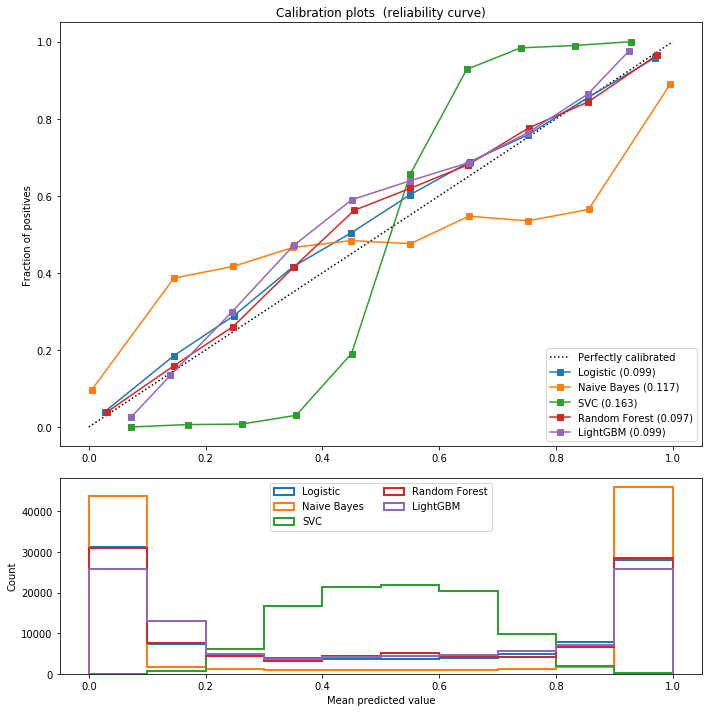

In [4]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
#    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
#    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (GaussianNB(), 'Naive Bayes'),
                      (LinearSVC(max_iter=10000), 'SVC'),
                      (RandomForestClassifier(), 'Random Forest'),
                      (est, name)
                     ]:
        prob_pos, prob_pos_sigmoid, prob_pos_isotonic = train_model(clf, pd.DataFrame(X_train), pd.Series(y_train), pd.DataFrame(X_test))

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (name, clf_score))
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
        
#        if name == 'LightGBM':
#            clf_score_sigmoid = brier_score_loss(y_test, prob_pos_sigmoid, pos_label=y.max())
#            clf_score_isotonic = brier_score_loss(y_test, prob_pos_isotonic, pos_label=y.max())
#            fraction_of_positives_sigmoid, mean_predicted_value_sigmoid = calibration_curve(y_test, prob_pos_sigmoid, n_bins=10)
#            fraction_of_positives_isotonic, mean_predicted_value_isotonic = calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
#            ax1.plot(mean_predicted_value_sigmoid, fraction_of_positives_sigmoid, "s-", label="%s (%1.3f)" % (name+' +sigmoid', clf_score_sigmoid))
#            ax1.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, "s-", label="%s (%1.3f)" % (name+' +isotonic', clf_score_isotonic))

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.savefig('../output/toydata_calibration_curve.png', dpi=300)

# Plot calibration curve for Linear SVC
plot_calibration_curve(lgb.LGBMClassifier(
            objective='binary',
            max_depth=8,
            num_leaves=2 ** 8,
            subsample=0.8,
            random_state=0,
            metric='auc',
            learning_rate=0.01,
            n_estimators=100000000
        ), "LightGBM", 2)